<b>Import necessery libraries</b>


In [92]:
import spacy
import string
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from azureml.core import Experiment
from azureml.core import Workspace
from azureml.data import DataType
from spacy.cli.download import download as spacy_download
import os 
from os.path import join as osjoin
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

<b>import Texts</b>

In [2]:
from azureml.core import Workspace, Dataset

subscription_id = '6ed9d167-b2e6-41b8-9500-35e6df64d9dc'
resource_group = 'MLRG'
workspace_name = 'erbbimlws'

workspace = Workspace(subscription_id, resource_group, workspace_name)

<b>Loading the Greek language tools</b>

In [3]:
spacy_download('el_core_news_sm')
nlp =spacy.load('el_core_news_sm', disable=['tagger', 'parser', 'ner'])

✔ Download and installation successful
You can now load the model via spacy.load('el_core_news_sm')


<b>Parameter definitions</b>

In [4]:
#minimum number of tokens in the texts
minCount = 1
#ngrams parameters
mindf,minngram,maxngram = 3,2,2
#keep empty tokens
deleteEmptyTokens = True
fileName = 'Omilia_Vana'

<b>Regular expressions definitions</b>

In [5]:
corDict ={'αναμονης':'χρονος αναμονης',
            'χρονος':'χρονος αναμονης',
            'τηλεφωνικο':'τηλεφωνικο κεντρο',
            'κεντρο':'τηλεφωνικο κεντρο',
            'ταχυτερη':'ταχυτερη εξυπηρετηση', 
            'εξυπηρετηση':'ταχυτερη εξυπηρετηση',
            'ιμαιλ':'email',
            'γιουζερνεημ' : 'username',
            'τηλεφωνικη':'τηλεφωνικη επικοινωνια', 
            'επικοινωνια':'τηλεφωνικη επικοινωνια',
            'αρχικη':'αρχικη αναμονη',
            'αναμονη':'αρχική αναμονη'}

In [6]:
p1 = re.compile('δεν απαντ.{1,3}\s{0,1}',re.IGNORECASE)
p2 = re.compile('\sδα\s',re.IGNORECASE)
p3 = re.compile('δε.{0,1}\s.{0,3}\s{0,1}βρ.{1,2}κ.\s{0,1}',re.IGNORECASE)
p4 = re.compile('[^\d]?\d{10}')
p5 = re.compile('[^\d]?\d{18}|[^\d]\d{20}')
p6 = re.compile('δε[ ν]{0,1} (επιθυμ[α-ω]{2,4}?|[ήη]θ[εέ]λ[α-ω]{1,3}?|θελ[α-ω]{1,4}|.{0,20}ενδιαφ[εέ]ρ[α-ω]{2,4})',re.IGNORECASE)
p7 = re.compile('δε[ ν]{0,1} (μπορ[α-ω]{2,5}|.εχει)',re.IGNORECASE)
p8 = re.compile('(δεν|μη).*διαθεσιμ[οη]ς{0,1}?',re.IGNORECASE)
p9 = re.compile('(δεν|μη)+.*εφικτη?',re.IGNORECASE)
p10 = re.compile('δε[ ν]{0,1}.{0,20}θετικ[οόήη]ς{0,1}',re.IGNORECASE)

p11 = re.compile('δεν εξυπηρε.?(.*)',re.IGNORECASE)
p12 = 

<b>Functions definitions</b>

In [8]:
def loadStopWords(ws):
    #A dataset containing the Greek stop words has been created
    #the function loads this dataset as a dataframe
    dataset = Dataset.get_by_name(ws, name='stopWords_gr')
    sw = set(dataset.to_pandas_dataframe().squeeze())
    return sw

In [9]:
def replaceTerm(text):
    #This function uses the above defined regular expressions to replace text
    #The order of the rules is importand
    #Compinations of two or more words, are concatenated, in order to be considered as a single token
    text = text.replace('γιούροφοουν','europhone')
    text = text.replace('ιμπάνκινγκ','eBanking')
    text = text.replace('μπάνκινγκ','banking')
    text = text.replace('τέλεφοουν','telephone')
    text = text.replace('γιούρομπανκ','eurobank')
    text = text.replace('βάιμπερ','viber')
    text = text.replace('ιμαιλ', 'email')
    text = text.replace('γιουζερνεημ', 'username')
    text = text.replace('εητιέμ', 'ATM')
    
    text = p5.sub(' λογαριασμός ',text)
    text = p4.sub(' τηλεφωνο ',text)
    text = p6.sub(' δενθελειδενενδιαφερεται ',text)
    text = p10.sub(' δενθελειδενενδιαφερεται ',text)
    text = p7.sub(' δενεχειδενμπορει ',text)
    text = p8.sub(' δενειναιδιαθεσιμος ',text)
    text = p9.sub(' ανεφικτη ',text)
    text = text.replace('-banking','banking')
    text = text.replace('v banking','vbanking')
    text = text.replace('e banking','ebanking')
    text = text.replace('follow up','followup')
    text = text.replace('fup','followup')
    text = text.replace('f/up','followup')
    text = text.replace('πυρ/ριο','πυρασφαλιστηριο')
    text = text.replace('safe drive','safedrive')
    text = text.replace('safe pocket','safepocket')
    text = text.replace('alphabank','alpha')
    text = text.replace('sweet home smart','sweethomesmart')
    text = text.replace('sweet home','sweethome')
    text = text.replace('eξασφαλιζω','εξασφαλιζω')
    text = text.replace('credit card','creditcard')
    text = text.replace('debit card','debitcard')
    text = text.replace('life cycle','lifecycle')
    text = text.replace('π/κ','πκ')
    text = text.replace('td','πκ')
    text = text.replace('α/κ','ακ')
    text = text.replace('δ/α','δεναπαντα ')
    text = text.replace('εκτος αττικης','εκτοςαττικης ')
    #τδ
    text = p1.sub(' δεναπαντα ',text)
    text = p2.sub(' δεναπαντα ',text)
    text = p3.sub(' δεντονβρηκα ',text)
    text = p11.sub('δενεξυπηρετηθηκα', text)
    
    return text

In [10]:
def remove_ton(text):
    #removes punctuation, αφαιρεί τους τόνους
    diction = {'ά':'α','έ':'ε','ί':'ι','ό':'ο','ώ':'ω','ύ':'υ','ή':'η'}
    for key in diction.keys():
        text = text.replace(key, diction[key])
    return text   

In [11]:
def clean_text(text,sw):
    #This function performs text cleansing and returns the clean and lemmatized version of the original text
    #convert to lower text 
    text = str(text).lower()

    #replacements either by rules or regular expressions
    text = replaceTerm(text)
    
    # remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]

    # αφαιρούνται οι τόνοι
    text = [remove_ton(x) for x in text]

    # remove stop words
    text = [x for x in text if x not in sw]
    
    #replacements either by rules or regular expressions
    #text = [replaceTerm(x) for x in text]

    #remove quotes
    text = [x.replace('quot;','').replace('&quot','') for x in text if x not in {'quot','amp'}]
    
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)] #addition to return even empty tokens
    
    # remove empty tokens
    #text = [t for t in text if len(t) > 0] #addition to return even empty tokens
    
    # remove amp & quot
    text = [x for x in text if x not in ['quot','amp']]
    
    # remove words with only one letter
    text = " ".join([t for t in text if len(t) > -1]) #addition to return even empty tokens
    
    # lemmatize text
    text = " ".join([t.lemma_ for t in nlp(text, disable=['tagger', 'parser', 'ner','tok2vec', 'morphologizer', 'parser', 'senter', 'attribute_ruler',  'ner'])])
    
    return(text)

In [12]:
def load_correctDict(ws):
    #it creates a dictionary out of a dataset that containes pairs of (original term, corrected term)    
    dataset = Dataset.get_by_name(ws, name='correct_Tokens')    
    corDict = dict(dataset.to_pandas_dataframe().to_dict("split")['data'])
    return corDict

In [13]:
def correct(x,corDict):
    #uses the dictionary to correct the terms
    if x in corDict.keys():
        y = corDict[x]
    else:
        y = x
    return y    

In [14]:
def get_ngrams(idf,mindf,minngram,maxngram,idField):
    #this function returns the bi-grams and tri-grams
    tfidf = TfidfVectorizer(min_df = mindf, ngram_range = (minngram,maxngram))
    tfidf_result = tfidf.fit_transform(idf['tokenized']).toarray()
    tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
    tfidf_df.columns = [str(x) for x in tfidf_df.columns]
    df_i = pd.concat([df[[idField]],tfidf_df],axis=1).melt(id_vars=[idField],value_vars = tfidf_df.columns).dropna()
    df_i = df_i[df_i['value'] > 0]
    return df_i

In [15]:
def cleanComments(df,sw,idField,textField):
    #applies the clean text function to all texts contained in the dataset
    df = df[[idField,textField]]
    df['tokenized'] = df[textField].apply(clean_text, sw = sw)
    df = df.fillna('N/A')
    df['variable'] = df['tokenized'].str.split()
    return df

In [16]:
def getTokens(df,sw,idField,textField):
    #The variable columns is a list. The explode method "unpivots this list"
    df = cleanComments(df,sw,idField,textField)
    df_f = df.explode('variable')[[idField,'variable']]
    return df_f

In [17]:
def getTokencount(df_f,minCount):
    #calculate the number of occurances (counts) of each token
    #tokens with count less than mincount are set to blank
    tokenCount = df_f['variable'].value_counts().to_dict()
    
    df_f['value'] = df_f['variable'].map(tokenCount)
   
    df_f.loc[(df_f['value'] < minCount), 'variable'] = ' ' #addition to return even empty tokens
    
    return df_f

In [18]:
def performNLP(workspace, minCount, mindf, minngram, maxngram, deleteEmptyTokens, df, idField, textField, corDict):
    sw = loadStopWords(workspace)
    
    df = cleanComments(df,sw,idField,textField)
    
    df_f = getTokens(df,sw,idField,textField)
    
    df_f = df_f.fillna(' ')
    
    df_f = getTokencount(df_f, minCount)
    
    try:
        df_f = df_f.append(get_ngrams(df, mindf, minngram, maxngram, idField))
    except:
        print('no bigramms or trigramms were added')
    
    #corDict = load_correctDict(workspace)     
    
    df_f['token'] = df_f['variable'].apply(lambda x : correct(x,corDict))
    df_f['token'] = df_f['variable']
    df_f.loc[(df_f['token'].str.len() < 2), 'token'] = ' ' #single character tokens are set to blank
    
    df_f = df_f.sort_values([idField,'token'])
    
    if deleteEmptyTokens:
        df_f = df_f[df_f['token'] != ' ']
    
    df_f = df_f[[idField, 'token']].drop_duplicates()
    
    return df_f

In [19]:
def loadTexts(workspace,datasetName,idField,textField):
    #loads the texts to be analyzed
    dataset = Dataset.get_by_name(workspace, name=datasetName)
    df = dataset.to_pandas_dataframe()
    df= df[[idField,textField]]
    return df   

In [20]:
def exportResults(fileName,df_f):
    df_f.to_csv(fileName+'.txt',sep =',',line_terminator='\r\n',index = False)
    fil = [os.getcwd()+'/'+ fileName+'.txt']
    #datastore.upload_files(fil, target_path='UI/NLP', overwrite=True, show_progress=True)

In [21]:
df = pd.read_excel('./xlsxFiles/NPS_CSAT_0102_2022.xlsx',engine='openpyxl',index_col = None)

In [93]:
df_f = performNLP(workspace,minCount,mindf,minngram,maxngram,deleteEmptyTokens,df,'id','NPS_UTTERANCE_', corDict)

In [227]:
exportResults(fileName,df_f)

#run.complete()

Word Cloud

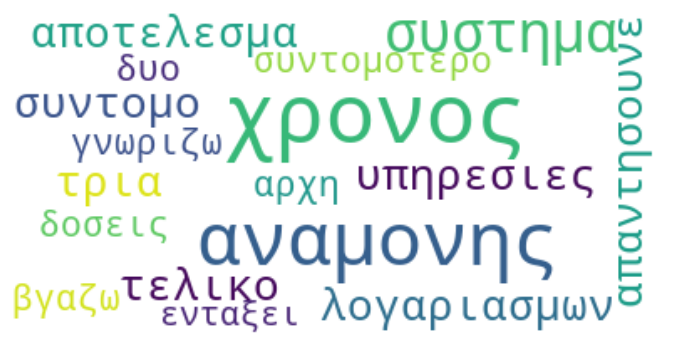

In [29]:
from wordcloud import WordCloud, ImageColorGenerator

import matplotlib.pyplot as plt
#%matplotlib inline

#corpus = [", ".join(token for token in merged.token)]
#vectorizer = CountVectorizer()
#x = vectorizer.fit_transform(corpus)
#freq = df_f.groupby(['token']).count().reset_index().sort_values(by = 'id', ascending = False)

wordcloud = WordCloud(max_font_size=50, max_words=100, collocations = False, 
                      collocation_threshold = 3, 
                      background_color="white").generate_from_text(sample)

plt.figure(figsize = (12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [40]:
sample = df_f.groupby(['token']).count().sort_values(by = 'id', ascending = False).reset_index()
#.droplevel(0, axis='columns')
#.reset_index(drop = True)